# *MODELO FINAL*

## 1. Selección del Mejor Modelo
Tras evaluar distintos modelos (KNN, Árboles de Decisión, Regresión Logística, SVM, etc) se comprobó que el SVM con Kernel RBF y los hiperparámetros óptimos:
* C=10
* gamma = 'scale'
* kernel = 'rbf'

presenta el mejor desempeño en términos de Balanced Accuracy en el conjunto de validación interna. Esto lo convierte en nuestro candidato para el modelo final

## 2. Evaluación Outer y Estimación del Desempeño futuro
La estrategia de evaluación outer consiste en separar los datos en dos partes:

* Train (2/3): Para realizar el ajuste y selección de modelos
* Test (1/3): Para obtener una estimación real de rendimiento que tendría el modelo en una competición

Aunque durante la práctica se ha usado esta partición para evaluar el desempeño, en el paso final se reentrena al modelo usando todos los datos disponibles. 

## 3.Entrenamiento final y Guardado del Modelo
En este paso se reentrena al modelo SVM Final utilizando todos los datos. Se aplica un preprocesado antes de entenar el clasificador. Finalmente guardamos el modelo en modelo_final.pkl

In [10]:
# Importamos las librerías necesarias
import pandas as pd
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
# ---------------------------
# 3.1. Cargar y Preprocesar los Datos
# ---------------------------
# Cargamos los datos disponibles de entrenamiento y el dataset de competición
datos_generales = pd.read_csv('./attrition_availabledata_10.csv.gz')
datos_test = pd.read_csv('./attrition_competition_10.csv.gz')  # Datos para el test de la competición

# Convertimos la variable objetivo a numérica: 'Yes' -> 1, 'No' -> 0
datos_generales['Attrition'] = datos_generales['Attrition'].map({'Yes': 1, 'No': 0})

# Eliminamos columnas que no aportan información (IDs, columnas constantes, etc.)
X = datos_generales.drop(columns=['Attrition', 'EmployeeID', 'Over18', 'EmployeeCount', 'StandardHours'])
y = datos_generales['Attrition']

# Definimos los nombres de variables según su tipo (estas definiciones se han usado en el preprocesado)
categorical_features = ['Department', 'JobRole', 'EducationField']
ordinal_features = ['BusinessTravel', 'Gender', 'MaritalStatus']
# Nota: el resto de las variables numéricas se mantienen sin transformación adicional
valores_ordinales = [
    ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'],
    ['Male', 'Female'],
    ['Single', 'Married', 'Divorced']
]

# Creamos el preprocesador para transformar variables categóricas y ordinales
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),  # Variables categóricas sin orden
        ('ord', OrdinalEncoder(categories=valores_ordinales), ordinal_features)  # Variables ordinales
    ],
    remainder='passthrough'  # El resto de variables (numéricas) se mantienen
)

# Aplicamos el preprocesado a todo el dataset de entrenamiento
X_preprocessed = preprocessor.fit_transform(X)
# Obtenemos nombres de columnas tras la transformación para posibles análisis posteriores
columnas_preprocesadas = preprocessor.get_feature_names_out()

# Convertimos el resultado a DataFrame (opcional, para visualización)
X_preprocessed = pd.DataFrame(X_preprocessed, columns=columnas_preprocesadas)

# ---------------------------
# 3.2. Entrenamiento del Modelo Final
# ---------------------------
# Definimos el pipeline final: imputación (por si acaso), escalado y SVM con hiperparámetros óptimos
final_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()),
    ('svm', SVC(C=10, gamma='scale', kernel='rbf', probability=True))  # Se incluye probability=True si se requieren probabilidades
])

# Entrenamos el modelo final con la totalidad de los datos preprocesados
final_pipeline.fit(X_preprocessed, y)

# Realizamos predicciones en el conjunto de entrenamiento
y_pred = final_pipeline.predict(X_preprocessed)

# Calculamos la balanced accuracy
balanced_accuracy = balanced_accuracy_score(y, y_pred)
print(f"Balanced Accuracy en el conjunto de entrenamiento: {balanced_accuracy:.4f}")

# Guardamos el modelo final en un fichero 'modelo_final.pkl'
with open('modelo_final.pkl', 'wb') as f:
    pickle.dump(final_pipeline, f)

print("Modelo final guardado en 'modelo_final.pkl'")


Balanced Accuracy en el conjunto de entrenamiento: 0.9979
Modelo final guardado en 'modelo_final.pkl'


## 4.Generación de Predicciones para la Competición
El siguiente paso es utilizar el modelo final para generar predicciones sobre el conjunto de datos de la competición. Para ello se debe aplicar el mismo preprocesado que a los datos de entrenamiento. El fichero resultante se guardará como predicciones.csv

In [11]:
# ---------------------------
# 4.1. Preprocesamiento de los Datos de la Competición
# ---------------------------
# Para el conjunto de competición, eliminamos las mismas columnas que en el entrenamiento.
# Se asume que el dataset de competición no contiene la variable 'Attrition'
X_competicion = datos_test.drop(columns=['EmployeeID', 'Over18', 'EmployeeCount', 'StandardHours'])

# Aplicamos el preprocesado usando el preprocessor ya ajustado (fit) en el conjunto de entrenamiento
X_competicion_preprocessed = preprocessor.transform(X_competicion)
# Convertimos a DataFrame para mayor claridad
X_competicion_preprocessed = pd.DataFrame(X_competicion_preprocessed, columns=columnas_preprocesadas)

# ---------------------------
# 4.2. Generar Predicciones
# ---------------------------
# Utilizamos el modelo final para predecir las clases (o probabilidades si se requiere)
predicciones = final_pipeline.predict(X_competicion_preprocessed)

# Si se desea guardar además las probabilidades, se puede obtener:
# prob_pred = final_pipeline.predict_proba(X_competicion_preprocessed)

# Creamos un DataFrame con las predicciones
df_predicciones = pd.DataFrame({
    'Predicted_Attrition': predicciones
})

# Guardamos el DataFrame en un fichero CSV
df_predicciones.to_csv('predicciones.csv', index=False)

print("Predicciones guardadas en 'predicciones.csv'")


Predicciones guardadas en 'predicciones.csv'


# 5. Tarea Adicional


Para esta tarea adicional, hemos decicido utilizar la herramienta SHAP, para interpretar nuestro modelo final.

SHAP (SHapley Additive exPlanations) es una herramienta basada en la teoría de juegos que permite cuantificar la contribución de cada variable a la predicción de un modelo. Entre sus principales ventajas destacan:

* **Interpretabilidad Local y Global**: SHAP ofrece explicaciones tanto a nuvel individual (por cada predicción) como a nivel global (importancia de las variables a lo largo de todo el conjunto). Esto permite identificar cómo cada característica influye en cada decisión del modelo.

* **Consistencia y solidez**: Los valores de Shapley garantizan que la contribución de cada característica se mida de forma justa, lo que otorga una interpretación coherente y consistente.

* **Modelo-agnóstico**: A diferencia de otros métodos que se basan en la estructura interna del modelo (por ejemplo, la importancia basada en la impureza de los árboles en RandomForest), SHAP puede aplicarse a cualquier modelo.

* **Transparencia**: Integrar SHAP en el análisis del modelo permite detectar posibles sesgos o relaciones inesperadas entre variables, lo cual es fundamental para generar confianza en la toma de decisiones basadas en inteligencia artificial.

Realizar esta tarea extra con SHAP resulta especialmente interesante en comparación con construir otro modelo como un RandomForest o una red neuronal. Aunque estos modelos pueden ofrecer buenos resultados, la interpretación de sus resultados (por ejemplo, mediante la importancia de variables basada en el Gini o técnicas de regularización) suele ser menos precisa y profunda. En cambio, al interpretar el modelo SVM seleccionado con SHAP, se obtiene una explicación detallada y cuantitativa de la influencia de cada característica en la predicción, lo cual añade un valor extra al análisis, especialmente en contextos donde la explicabilidad es crucial.

## 5.1 Código para usar SHAP en nuestro modelo final

100%|██████████| 10/10 [00:01<00:00,  9.24it/s]


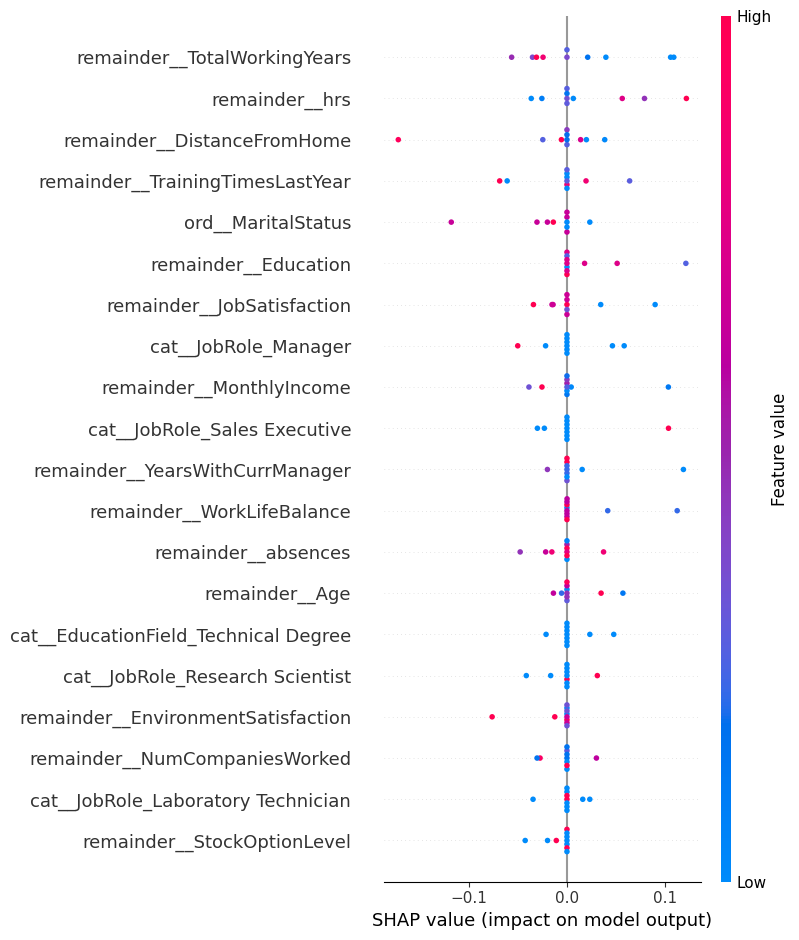

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Seleccionar una muestra representativa del conjunto preprocesado para el fondo (background)
# Reducir el tamaño del fondo para acelerar el cálculo
X_background = X_preprocessed.sample(20, random_state=42)

# Definir la función de predicción asegurándonos de que se pasan los nombres de las columnas
def model_predict(data):
    # Convertir a DataFrame si es necesario
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=columnas_preprocesadas)
    return final_pipeline.predict_proba(data)[:, 1]

# Crear el explicador con KernelExplainer usando el fondo reducido
explainer = shap.KernelExplainer(model_predict, X_background)

# Seleccionar un subconjunto reducido de datos para explicar
X_explain = X_preprocessed.sample(10, random_state=42)

# Calcular los valores SHAP para el subconjunto seleccionado, limitando nsamples para acelerar el proceso
shap_values = explainer.shap_values(X_explain, nsamples=50)

# Visualizar el resumen de los valores SHAP para identificar la importancia de las variables
shap.summary_plot(shap_values, X_explain, feature_names=columnas_preprocesadas)
plt.show()

# Explicación local de una instancia en particular
i = 0  # índice de la instancia a explicar
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], X_explain.iloc[i], feature_names=columnas_preprocesadas)



La gráfica SHAP permite ver qué variables han influido más en las predicciones del modelo SVM sobre la variable Attrition. También muestra cómo valores altos o bajos de cada variable afectan individualmente a cada empleado.

En este caso, la variable más influyente es remainder__TotalWorkingYears, lo que indica que el número total de años trabajados es clave en la decisión. Empleados con más años suelen tener valores SHAP negativos, lo que reduce la probabilidad de abandono. También destacan variables como remainder__hrs, DistanceFromHome o TrainingTimesLastYear. Por ejemplo, empleados que viven lejos tienden a tener más probabilidad de dejar la empresa, mientras que recibir más formación puede asociarse a menor riesgo.

Las variables categóricas como el estado civil o el rol profesional (JobRole_Manager, MaritalStatus) también influyen, aunque en menor medida. Tener un cargo alto o estar casado parece relacionarse con mayor estabilidad.

En general, el gráfico muestra que la experiencia, la distancia al trabajo y otros factores numéricos son los que más afectan al resultado. Se observan patrones coherentes: valores altos en algunas variables empujan la predicción hacia Attrition = 1, mientras que en otras hacen lo contrario. Esto permite confiar más en el modelo y entender mejor sus decisiones.
